In [2]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight
import os
import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [7]:
def loadLimits(f):
    T=uproot.open(f)['limit']
    return np.array(T['limit'].array())

def loadLimitFiles(mass,fpath):
    arr =[]
    ctau = []
    for f in glob.glob(fpath):
        # f= "../limit/combine/HNL_datacards/muon_v1/higgsCombine_HNL_muonType_mHNL4p0_pl*_comb.AsymptoticLimits.mH120.root"
        ct = f.split("/")[-1].split("_")[4].replace("pl","")
        xsec = f_xsec(mass)(float(ct))
#         print(ct,xsec)    
        signalName = "_".join(f.split("/")[-1].split("_")[1:-1])   
        card = os.path.dirname(f)+"/%s_CSC.txt"%signalName
        norm = float(open(card,'r').readline().split()[-1])
        limit = loadLimits(f)
#        print(len(limit))
        if len(limit) !=6:
            print("Problem loading limit for ",signalName)
        else:
            arr.append(loadLimits(f)*xsec/norm)
            ctau.append(float(ct))        
#         arr.append(loadLimits(f)*xsec)
#         ctau.append(float(ct))
    arr = np.array(arr)
    ctau = np.array(ctau)
    return arr,ctau

import math
def plotlimit(ax,expected_CLs,poi_values,showBands = True, legend=True):

    # expected CLs
    if legend:
        ax.plot(poi_values, expected_CLs[:, 2], "--", color="black", label=r"expected CL$_S$")
    else:
        ax.plot(poi_values, expected_CLs[:, 2], "--", color="black", label='_nolegend_')        
        
    if showBands:
        # 1 and 2 sigma bands
        if legend:
            sigOnelabel = r"expected CL$_S$ $\pm 1\sigma$"
            sigTwolabel = r"expected CL$_S$ $\pm 2\sigma$"            
        else:
            sigOnelabel = '_nolegend_'
            sigTwolabel = '_nolegend_'
            
        ax.fill_between(
            poi_values,
            expected_CLs[:, 1],
            expected_CLs[:, 3],
            color="limegreen",
            label=sigOnelabel,
        )
        ax.fill_between(
            poi_values,
            expected_CLs[:, 0],
            expected_CLs[:, 4],
            color="yellow",
            label=sigTwolabel,
            zorder=0,  # draw beneath 1 sigma band
        )
#     hep.cms.label(ax=ax,label="Preliminary",data=True,lumi="137")
    return ax
from HNLprocessor.util import f_xsec
from HNLprocessor.util import f_v2

## find intersection of limit band with theory xsec
from scipy.optimize import fsolve

def intersect2(funcs,xsec,x0):
    def eq(i):
        def eq_i(x):
            return np.log(funcs[i](x))-np.log(xsec(x)) 
        return eq_i
    if isinstance(x0,int):
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    else:
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    return np.array(sol)[:,0]

def intersect(funcs,xsec,x0):
    def eq(i):
        def eq_i(x):
            return funcs[i](x)-xsec(x) 
        return eq_i
    if isinstance(x0,int):
        sol =[]
        for i in range(len(funcs)):
            root= fsolve(eq(i),x0,full_output=True)  
            ## fill only the converged solution
            if root[2]==1:
                sol.append(root[0])
            else:
                sol.append([0])
    else:
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    return np.array(sol)[:,0]

from scipy.interpolate import Rbf,interp1d
from scipy import interpolate
import numpy as np
def interpolate1D(combineLimits,x,nBins=10,f="linear"):
    epsilon = 0.2
    smooth = 1
#     nBins = 10
    newLimits = []
#     xi = np.linspace(min(x),max(x),nBins)
    if nBins<0:
        xi = np.sort(x)
    else:
        xi = np.logspace(np.log10(min(x)),np.log10(max(x)),nBins)    

    funcs=[]
    for i in range(5):
        y = combineLimits[:,i]
#         rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)
        if f=="linear":
            rbfi = interp1d(x, y,fill_value="extrapolate")
        else:
            rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)            

        yi = rbfi(xi)
        newLimits.append(yi)
        funcs.append(rbfi)
    newLimits = np.array(newLimits).transpose()
    return newLimits, xi,funcs

def plotOneMass_fpath(fpath):
    mass = float(fpath.split("/")[-1].split("_")[2].replace("mHNL","").replace("p","."))            
    arr,ctau = loadLimitFiles(mass,fpath)
    ax, func = plotOneMass(arr,ctau,mass,r"$m_{HNL}^\mu=%.1fGeV$"%mass,True,None,True)
    return ax

def plotOneMass(arr,ctau,mass,label,showBand=True,ax=None,addTheory=True):
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)

    plt.style.use(hep.style.CMS) 

    if ax ==None:
        fig, ax = plt.subplots(figsize=(8,6))
    ax = plotlimit(ax,arr_i,ctau_i,showBand)
    if addTheory:
        ax.plot(ctau_i,f_xsec(mass)(ctau_i),label="Theory")

    ax.set_xlabel("ctau[mm]")
    ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend([label,"Theory"])
    return ax,funcs

def get_ct_xing(mass,fpath,init_ct):
    ## get limit and ctau from path
    arr,ctau = loadLimitFiles(mass,fpath)
    ## get iterpolated limit and ctau from path    
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)
    
    ct_xing = intersect(funcs,f_xsec(mass),init_ct)
    return ct_xing

def get_ct_xing_up(mass,fpath):
    arr,ctau = loadLimitFiles(mass,fpath)
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)    
    ct_xing = intersect(funcs,f_xsec(mass),int(min(ctau_i)))
    return ct_xing
def get_ct_xing_down(mass,fpath):
    arr,ctau = loadLimitFiles(mass,fpath)
    arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)    
    ct_xing = intersect(funcs,f_xsec(mass),int(max(ctau_i)))
    return ct_xing

def get_masses(fpath):
    ans =[p.split("/")[-1].split("_")[2].replace("mHNL","") for p in glob.glob(fpath+"/*comb*.txt") if not "bkg" in p]
    return np.unique(ans)

def fill_zeros(y1,y2):
    y1_new=[]
    y2_new= []
    if (not np.any(y1))or (not np.any(y2)):
        print("Invalid ctau!")    
    for i,(iy1,iy2) in enumerate(zip(y1,y2)):
        #fill y1_new
        if iy1!=0: y1_new.append(iy1)
        elif y2[i]!=0: y1_new.append(y2[i])
        elif y1_new[i-1]!=0: y1_new.append((y1_new[i-1]+y2_new[i-1])/2)
        # fill y2_new
        if iy2!=0: y2_new.append(iy2)
        elif y1[i]!=0: y2_new.append(y1[i])
        elif y2_new[i-1]!=0: y2_new.append((y2_new[i-1]+y1_new[i-1])/2)      
    return np.array(y1_new),np.array(y2_new)

def get_limits(basedir,masses_up,masses_down,debug=False):
    masses_str = get_masses(basedir)
    fpaths = []
    for mass_str in masses_str:
        fpaths.append( f'{basedir}higgsCombine_*_mHNL{mass_str}_pl*_comb*.root')
    limits_up,m_up = [],[]
    limits_down,m_down = [],[]    

    for fpath in fpaths:
        mass = float(fpath.split("/")[-1].split("_")[2].replace("mHNL","").replace("p","."))
        if mass in masses_up:
            ct_xing_up = get_ct_xing_up(mass,fpath)
            if debug:
                print(mass,ct_xing_up)              
            m_up.append(mass)              
        if mass in masses_down:
            ct_xing_down = get_ct_xing_down(mass,fpath)
            if debug:
                print(mass,ct_xing_down)            
            m_down.append(mass)
        ## Fill the invalid limit points
        if mass in masses_up and mass in masses_down:
            y_up_new, y_down_new = fill_zeros(ct_xing_up,ct_xing_down)            
            limits_up.append(f_v2(mass)(y_up_new))
            limits_down.append(f_v2(mass)(y_down_new))
            if debug:
                print(mass,y_up_new)     
                print(mass,y_down_new)
        elif mass in masses_up:
            if debug: print(mass,ct_xing_up)                        
            limits_up.append(f_v2(mass)(ct_xing_up))
        elif mass in masses_down:
            if debug: print(mass,ct_xing_down)            
            limits_down.append(f_v2(mass)(ct_xing_down))            
    return np.array(m_up),np.array(limits_up),np.array(m_down),np.array(limits_down)

# Load limits into arrays

In [39]:
arr_4GeV_CSC,ct_4GeV_CSC = loadLimitFiles(4,"../limit/combine/HNL_datacards/higgsCombine_HNL_muonType_mHNL4p0_pl*_CSC.AsymptoticLimits.mH120.root")
arr_4GeV_DT,ct_4GeV_DT = loadLimitFiles(4,"../limit/combine/HNL_datacards/higgsCombine_HNL_muonType_mHNL4p0_pl*_DT.AsymptoticLimits.mH120.root")

In [7]:
arr4p5GeV,ctau4p5GeV = loadLimitFiles(4.5,"../limit/higgsCombine_HNL_muonType_mHNL4p5_pl*_comb.AsymptoticLimits.mH120.root")
arr4p6GeV,ctau4p6GeV = loadLimitFiles(4.6,"../limit/higgsCombine_HNL_muonType_mHNL4p6_pl*_comb.AsymptoticLimits.mH120.root")
arr4p7GeV,ctau4p7GeV = loadLimitFiles(4.7,"../limit/higgsCombine_HNL_muonType_mHNL4p7_pl*_comb.AsymptoticLimits.mH120.root")
arr5GeV,ctau5GeV = loadLimitFiles(5,"../limit/higgsCombine_HNL_muonType_mHNL5p0_pl*_comb.AsymptoticLimits.mH120.root")
arr4GeV,ctau4GeV = loadLimitFiles(4,"../limit/higgsCombine_HNL_muonType_mHNL4p0_pl*_comb.AsymptoticLimits.mH120.root")
arr2GeV,ctau2GeV = loadLimitFiles(2,"../limit/higgsCombine_HNL_muonType_mHNL2p0_pl*_comb.AsymptoticLimits.mH120.root")

# Example of comparing two different limits

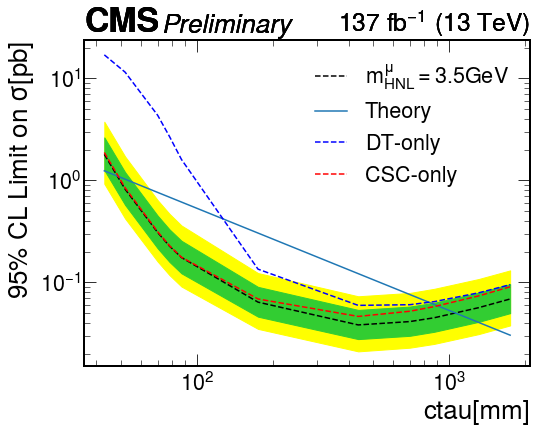

In [6]:
arr,ctau = loadLimitFiles(3.5,"../limit/combine/HNL_datacards/muon_v6/higgsCombine_HNL_muonType_mHNL3p5_pl*_comb.AsymptoticLimits.mH120.root")
arrDT,ctauDT = loadLimitFiles(3.5,"../limit/combine/HNL_datacards/muon_v6/higgsCombine_HNL_muonType_mHNL3p5_pl*_DT.AsymptoticLimits.mH120.root")
arrCSC,ctauCSC = loadLimitFiles(3.5,"../limit/combine/HNL_datacards/muon_v6/higgsCombine_HNL_muonType_mHNL3p5_pl*_CSC.AsymptoticLimits.mH120.root")

arr_i, ctau_i,funcs = interpolate1D(arr, ctau,-1)
arrDT_i, ctauDT_i,funcs = interpolate1D(arrDT, ctauDT,-1)
arrCSC_i, ctauCSC_i,funcs = interpolate1D(arrCSC, ctauCSC,-1)

ax, func_3 = plotOneMass(arr,ctau,3,r"$m_{HNL}^\mu=3.5GeV$",True)
plt.style.use(hep.style.CMS) 

ax = plotlimit(ax,arrDT_i,ctauDT_i,False)
ax = plotlimit(ax,arrCSC_i,ctauCSC_i,False)

# ax.plot(ctau,f_xsec(3)(ctau),label="Theory")
ax.get_lines()[2].set_color('b') 
ax.get_lines()[3].set_color('r')

ax.set_xlabel("ctau[mm]")
ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
ax.set_yscale("log")
ax.set_xscale("log")
# ax.legend()
ax.legend([r"$m_{HNL}^\mu=3.5GeV$","Theory","DT-only","CSC-only"])

# Limit v.s. ctau Per mass point

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


[715.27827223 556.46879804 261.79298281 200.         200.        ]


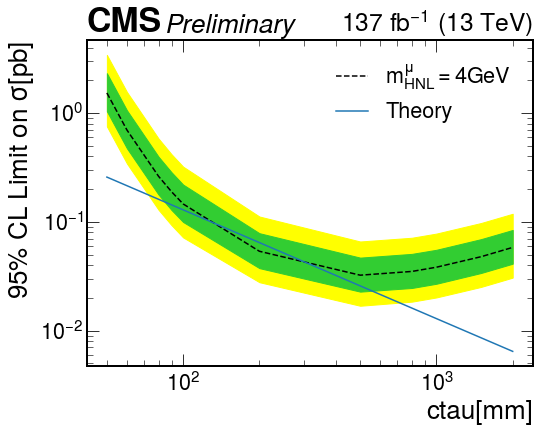

In [42]:
arr4GeV,ctau4GeV = loadLimitFiles(4,"../limit/combine/HNL_datacards/muon_v7/higgsCombine_HNL_muonType_mHNL4p0_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_4 = plotOneMass(arr4GeV,ctau4GeV,4,r"$m_{HNL}^\mu=4GeV$",False)

ct_xing_4 = intersect(func_4,f_xsec(4),200)
print(ct_xing_4)
# plt.savefig("./figures/result/AsymLimit_muon_4GeV.pdf")

[1024.16616871  834.19535117  635.42327203  459.04878801  200.85281777]
[ 51.1269451   61.15702044  68.68380016  83.40626147 168.52607102]


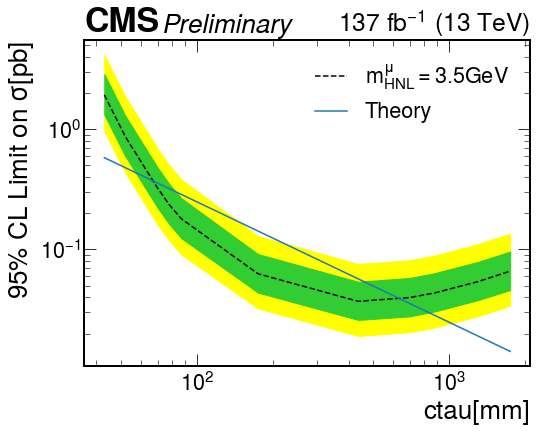

In [17]:
# arr,ctau = loadLimitFiles(3.5,"../limit/combine/HNL_datacards/muon_v7/higgsCombine_HNL_muonType_mHNL3p5_pl*_comb.AsymptoticLimits.mH120.root")
arr,ctau = loadLimitFiles(3.5,"../limit/combine/HNL_datacards/muon_v9/higgsCombine_HNL_muonType_mHNL3p5_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_3p5 = plotOneMass(arr,ctau,3.5,r"$m_{HNL}^\mu=3.5GeV$")
ct_xing_3p5 = intersect(func_3p5,f_xsec(3.5),[1000,800,700,200,200])
print(ct_xing_3p5)
ct_xing_3p5_up = intersect(func_3p5,f_xsec(3.5),[50,50,50,50,50])
print(ct_xing_3p5_up)
# plt.savefig("./figures/result/AsymLimit_muon_3p5GeV.pdf")

In [40]:
intersect2(func_3,f_xsec(3),[1000,800,700,200,200])

array([1343.7864304 , 1156.90516895,  960.53098004,  782.97961664,
        637.2040991 ])

[1541.30649649 1285.07642279 1033.21233679  809.40691136  637.85423177]
[  28.49685253   17.15898498 1033.21233679  809.4069114    56.77239607]


/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


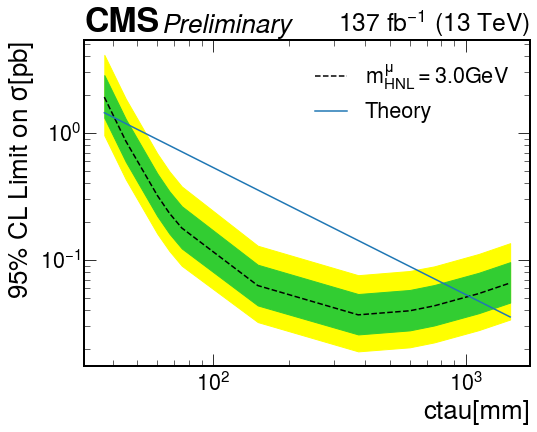

In [18]:
# arr,ctau = loadLimitFiles(3,"../limit/combine/HNL_datacards/muon_v7/higgsCombine_HNL_muonType_mHNL3p0_pl*_comb.AsymptoticLimits.mH120.root")
arr,ctau = loadLimitFiles(3,"../limit/combine/HNL_datacards/muon_v9/higgsCombine_HNL_muonType_mHNL3p0_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_3 = plotOneMass(arr,ctau,3,r"$m_{HNL}^\mu=3.0GeV$")
ct_xing_3 = intersect(func_3,f_xsec(3),[1000,800,700,200,200])
print(ct_xing_3)
ct_xing_3_up = intersect(func_3,f_xsec(3),[20,30,50,45,50])
print(ct_xing_3_up)
plt.savefig("./figures/result/AsymLimit_muon_3GeV.pdf")

[4077.04743134 3471.86253834 2867.34148957 2344.00888596 1948.24162329]


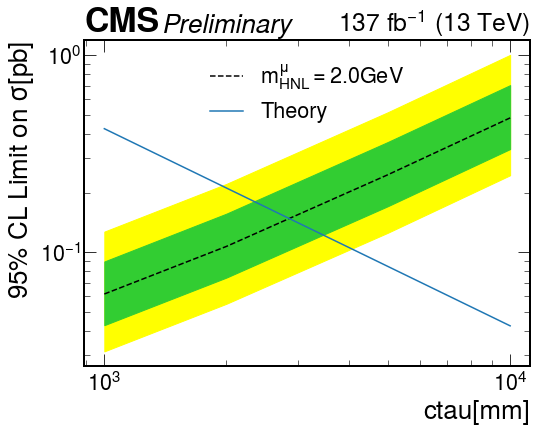

In [19]:
# arr,ctau = loadLimitFiles(2,"../limit/combine/HNL_datacards/muon_v7/higgsCombine_HNL_muonType_mHNL2p0_pl*_comb.AsymptoticLimits.mH120.root")
arr,ctau = loadLimitFiles(2,"../limit/combine/HNL_datacards/muon_v9/higgsCombine_HNL_muonType_mHNL2p0_pl*_comb.AsymptoticLimits.mH120.root")
arr = arr[ctau>=1e3]
ctau = ctau[ctau>=1e3]
ax, func_2 = plotOneMass(arr,ctau,2,r"$m_{HNL}^\mu=2.0GeV$")
ct_xing_2 = intersect(func_2,f_xsec(2),2000)
print(ct_xing_2)
# ct_xing_3_up = intersect(func_3,f_xsec(3),[20,30,50,45,50])
# print(ct_xing_3_up)
# plt.savefig("./figures/result/AsymLimit_muon_2GeV.pdf")

Problem loading limit for  HNL_muonType_mHNL1p0_pl100
[11978.69117078 10288.72379235  8856.15796951  7668.43800498
  6774.37900561]


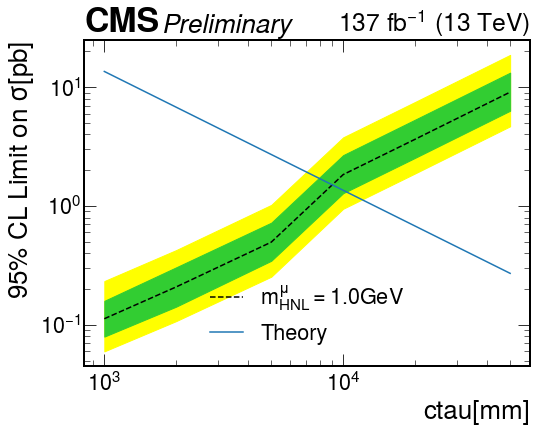

In [21]:
# arr,ctau = loadLimitFiles(1,"../limit/combine/HNL_datacards/muon_v7/higgsCombine_HNL_muonType_mHNL1p0_pl*_comb.AsymptoticLimits.mH120.root")
arr,ctau = loadLimitFiles(1,"../limit/combine/HNL_datacards/muon_v9/higgsCombine_HNL_muonType_mHNL1p0_pl*_comb.AsymptoticLimits.mH120.root")

ax, func_1 = plotOneMass(arr,ctau,1,r"$m_{HNL}^\mu=1.0GeV$")
ct_xing_1 = intersect(func_1,f_xsec(1),10000)
print(ct_xing_1)
# plt.savefig("./figures/result/AsymLimit_muon_1GeV.pdf")

# V^2 v.s. M limit

In [61]:
ct_xing_3_up

array([ 29.49684106,  21.86318654,  40.39837249, 782.97961663,
        54.79498443])

In [25]:
limits_v9 = np.array([f_v2(1)(ct_xing_1),
                   f_v2(2)(ct_xing_2),
                   f_v2(3)(ct_xing_3),
                   f_v2(3.5)(ct_xing_3p5),
                   f_v2(4)(np.array([ 545.0822784,305.69476147,200.00230833,  95.60042109,79.47867919]))                   
#                     np.array([2.5,3,4,6.5,10])*1e-7                   
                  ])

limits_up_v9 = np.array([
                   f_v2(3)(np.array([ 29.49684106,  21.86318654,  40.39837249, 50,54.79498443])),
                   f_v2(3.5)(ct_xing_3p5_up),
                   f_v2(4)(np.array([ 79.47867919,  95.60042109,200.00230833,305.69476147,545.0822784])),
                  ])

In [24]:
limits/limits_v9

array([[0.95753666, 0.9539409 , 0.95763639, 0.95769334, 0.95893396],
       [0.96209733, 0.95404165, 0.94753579, 0.94234368, 0.94156361],
       [0.94180105, 0.93325059, 0.92288559, 0.91594487, 0.90762085],
       [0.9349954 , 0.91946193, 0.89493297, 0.88643987, 0.79047176],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

In [26]:
limits_up/limits_up_v9

array([[1.        , 1.        , 1.        , 1.        , 1.        ],
       [1.05623786, 1.17621123, 1.05496654, 1.11729962, 1.93698718],
       [1.        , 1.        , 1.        , 1.        , 1.        ]])

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


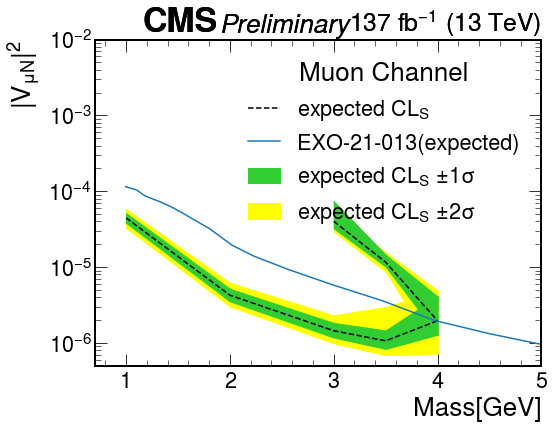

In [13]:
plt.style.use(hep.style.CMS) 

ct_xing_1 = intersect(func_1, f_xsec(1),10000)
ct_xing_2 = intersect(func_2,f_xsec(2),2000)
ct_xing_3 = intersect(func_3,f_xsec(3),[1000,800,700,200,200])
ct_xing_3p5 = intersect(func_3p5,f_xsec(3.5),[1000,800,700,200,200])

EXO = np.genfromtxt("../limit/EXO-21-013_mu_majorana.csv",delimiter=",")

limits = np.array([f_v2(1)(ct_xing_1),
                   f_v2(2)(ct_xing_2),
                   f_v2(3)(ct_xing_3),
                   f_v2(3.5)(ct_xing_3p5),
                   f_v2(4)(np.array([ 545.0822784,305.69476147,200.00230833,  95.60042109,79.47867919]))                   
#                     np.array([2.5,3,4,6.5,10])*1e-7                   
                  ])
masses = [1,2,3,3.5,4]

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,limits,masses)

ct_xing_3_up = intersect(func_3,f_xsec(3),[20,30,50,45,50])
ct_xing_3p5_up = intersect(func_3p5,f_xsec(3.5),[50,50,50,50,50])

limits_up = np.array([
                   f_v2(3)(np.array([ 29.49684106,  21.86318654,  40.39837249, 50,54.79498443])),
                   f_v2(3.5)(ct_xing_3p5_up),
                   f_v2(4)(np.array([ 79.47867919,  95.60042109,200.00230833,305.69476147,545.0822784])),
#                    f_ctau(4.6)(ct_xing_4p6_up),    
#                     np.array([10,6.5,4,3,2.5])*1e-7                      
                  ])
masses_up = [3,3.5,4]
ax = plotlimit(ax,limits_up,masses_up,True,False)

ax.plot(EXO[:,0],EXO[:,1],label="EXO-21-013(expected)")
ax.legend(["Expected","EXO-21-013(expected)",r"$\pm$1 std. deviation",r"$\pm$2 std. deviation"],loc=1)
ax.set_yscale("log")
ax.set_ylabel("$|V_{\mu N}|^2$")
ax.set_xlabel("Mass[GeV]")
ax.set_xlim(0.7,5)
ax.set_ylim(5e-7,1e-2)
ax.legend(title="Muon Channel")
fig.savefig("./figures/result/AsymLimit_VmuN_muon.pdf")

# Auto extraction

Problem loading limit for  HNL_muonType_mHNL1p0_pl100
1.0 [11978.69117078 10288.72379235  8856.15796951  7668.43800498
  6774.37900561]
1.0 [11978.69117078 10288.72379235  8856.15796951  7668.43800498
  6774.37900561]
2.0 [4077.04743134 3471.86253834 2867.34148957 2344.00888596 1948.24162329]
2.0 [4077.04743134 3471.86253834 2867.34148957 2344.00888596 1948.24162329]
3.0 [ 0.         34.41331099 41.87833261 48.4531299  56.77239607]
3.0 [1541.30649619 1285.07642781 1033.21233679  809.40691142  637.85423215]
3.0 [1541.30649619   34.41331099   41.87833261   48.4531299    56.77239607]
3.0 [1541.30649619 1285.07642781 1033.21233679  809.40691142  637.85423215]
3.2 [39.42782433 44.97061584 51.14613968 60.8757705  69.40640023]
3.2 [1308.42223486 1082.11201466  859.13939429  660.69025819  496.30543541]
3.2 [39.42782433 44.97061584 51.14613968 60.8757705  69.40640023]
3.2 [1308.42223486 1082.11201466  859.13939429  660.69025819  496.30543541]
3.5 [ 51.1269451   61.15702044  68.68380016  83.4062

(exptext: Custom Text(0.001, 1, 'CMS'),
 expsuffix: Custom Text(0.001, 1.005, 'Preliminary'))

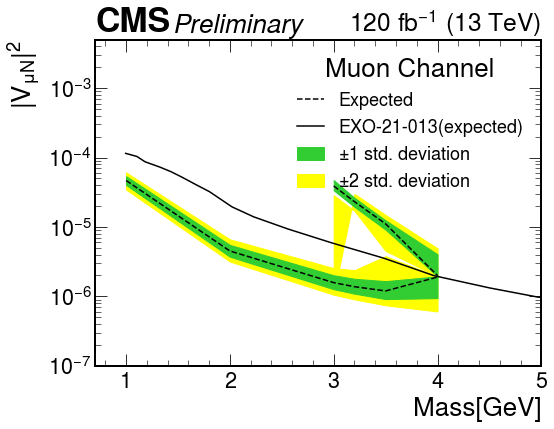

In [14]:
m_down = [1,2,3,3.2,3.5,4]
m_up   =     [3,3.2,3.5,4]

limits = get_limits("../limit/combine/HNL_datacards/muon_v9/",m_up,m_down,True)

plt.style.use(hep.style.CMS) 

EXO = np.genfromtxt("../limit/otherHNLlimits/EXO-21-013_mu_majorana.csv",delimiter=",")

fig, ax = plt.subplots(figsize=(8,6))
# ax = plotlimit(ax,limits,masses)
ax = plotlimit(ax,limits[1],limits[0])
ax = plotlimit(ax,limits[3],limits[2],True,False)

ax.plot(EXO[:,0],EXO[:,1],label="EXO-21-013(expected)",color='black')

ax.legend(["Expected",
           "EXO-21-013(expected)",
           r"$\pm$1 std. deviation",
           r"$\pm$2 std. deviation"],
          loc=1,fontsize='x-small',
          title="Muon Channel")
# ax.legend()
ax.set_yscale("log")
ax.set_ylabel(r"$|V_{\mu N}|^2$")
ax.set_xlabel("Mass[GeV]")
ax.set_xlim(0.7,5)
ax.set_ylim(1e-7,5e-3)
hep.cms.label(ax=ax,label="Preliminary",data=True,lumi="120")
# fig.savefig("./figures/result/AsymLimit_VmuN_muon.pdf")